In [1]:
# Jupter notebook magic
%matplotlib inline

import os
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from datetime import datetime, timedelta
from copy import copy
import geopandas as gpd
import geoplot as gplt
from PyAstronomy import pyasl


import himatpy, himatpy.GRACE_MASCON.pygrace, himatpy.MAR.utils
from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, masked_mascon_gdf,grace_data_df,\
                                          get_full_trend,trend_analysis, get_cmwe_trend_analysis, select_mascons, \
                                          aggregate_mascons)
from himatpy.MAR.utils import save_agg_mascons,  MAR_trend, subset_data


from himatpy.MAR import utils as MARutils

from mpl_toolkits.axes_grid1 import make_axes_locatable
import geoplot.crs as gcrs

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/srv/conda/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Work flow of MAR data analysis
This notebook outlines the work flow of MAR data analysis, from data access to making plots of trend comparison with GRACE data.


Zheng Liu, Anthony Arendt APL UW

### Download MAR data from NSIDC 
By default, data is stored at Data/MAR.

In [ ]:
MARutils.download_MAR(short_name = 'HMA_MAR3_5',
                      version = '1',
                      time_start = '2000-01-01T00:00:00Z',
                      time_end = '2000-03-31T23:59:59Z',
                      polygon = '',
                      filename_filter = '*'
                     )

### Subsetting the MAR data
Selecting variables of interest and store them either locally as netcdf or to s3 bucket as zarr. The latter approach is preferred and will be implemented soon. Here, we store subsetted data under SUB/MAR

In [3]:
DNAME    = 'MAR'
MAR_locl = os.path.join( os.getcwd() , 'Data', DNAME ) 
SUB_locl = os.path.join( os.getcwd() , 'SUB' , DNAME ) 
marfns   = sorted(glob(MAR_locl+'/*.nc'))
if not os.path.exists(SUB_locl): os.makedirs(SUB_locl)

# -- try out two files first
#marfns = marfns[:2]
for ifn, tfn in enumerate(marfns):
    sdir,sfn = os.path.split(tfn)
    print(ifn,sfn)
    ofn = os.path.join(SUB_locl,sfn)
    # --- by default, SMB is saved, other variables can be selected using the keepVars list
    subset_data(tfn,ofn)
    

0 HMA_MAR3_5_ICE.2000.01-12.h22.nc
1 HMA_MAR3_5_ICE.2001.01-12.h23.nc


### Aggregate MAR data into GRACE mascons
The MAR data are aggregated into GRACE mascons and saved to files.
This aggregated data will be used for further analysis. 

This is done by two steps: 
#### Step 1: read in GRACE mascons information.
First find out the mascons in the MAR domain.

In [4]:
# ---> use MAR grid to locate mascons in MAR domain
Grace_fn = 'Data/Grace/GSFC.glb.200301_201607_v02.4-ICE6G.h5'
# ---> use local copy
grace_file = os.path.abspath(Grace_fn)
f = extract_grace(grace_file,printGroups=False)

# --- save the GRACE mascon info into file for future access

subfns = sorted(glob(SUB_locl+'/*.nc'))
ds = xr.open_dataset(subfns[0])
MAR_mascons_fn = 'MAR_mascons.geojson'
masked_gdf = masked_mascon_gdf(f,ds,mascons_fn = MAR_mascons_fn,verbose=True)

ds.close()   



Data extracted: 
... read info of mascons in domain from MAR_mascons.geojson ...


#### Step 2:
Then, aggregate MAR data using GRACE mascon info stored in masked_gdf . 
The aggregated data will be saved under agg_MAR . 

In [ ]:
fnlist = subfns
# --- try the first file for example, this is going to take a while ...
#fnlist = [subfns[0]]
agg_dir = 'MAR_mascon'
save_agg_mascons(fnlist,agg_dir,masked_gdf)

### Now, we can read GRACE water content data and compare with MAR
#### Example 1. Compare the regional maps of trend

In [7]:
# ---> Read GRACE data within MAR domain into a dataframe:
gracedf = grace_data_df(f,masked_gdf)
f.close()
# --- SET THIS FLAG TO True IF RUNNING FOR THE FIRST TIME !!!
re_run = False

print('... computing Grace trend ...')
GRC_trend_fn = 'HMA_grc_trend.geojson'
GRC_pvals_fn = 'HMA_grc_trend.csv'
if re_run:
    # --- get_cmwe_trend_analysis calculate the linear trend and save to file
    HMA_w_trend = get_cmwe_trend_analysis(masked_gdf, f)
    HMA_w_trend.to_file(GRC_trend_fn,driver='GeoJSON')
    # --- get_full_trend return the full paramters of the least squre trend fit
    #     and save to csv file
    grc_pval_df = get_full_trend(gracedf)
    grc_pval_df.to_csv(GRC_pvals_fn,index=False)
else:
    HMA_w_trend = gpd.read_file(GRC_trend_fn)
    grc_pval_df = pd.read_csv(GRC_pvals_fn)
    
agg_fns = sorted(glob(agg_dir+'/*.nc'))

print('... computing MAR trend ...')
mar_pvals_fn = 'HMA_mar_trend.csv'
mar_pnice_fn = 'HMA_mar_pnice.csv'
if re_run:
    # --- calculating trend for SMB_ice in each mascon and save to csv file
    vname  = 'SMB_ice'
    mar_pval_df  = MAR_trend(agg_fns,vname,t_start='2003-01-07',t_end='2015-12-31')
    mar_pval_df.to_csv(mar_pvals_fn,index=False)
    # --- calculating trend for SMB_ice in each mascon and save to csv file
    mar_pnice_df = MAR_trend(agg_fns,'SMB_other',t_start='2003-01-07',t_end='2015-12-31')
    mar_pnice_df.to_csv(mar_pnice_fn,index=False)
else:
    # --- read trend files if they have been generated
    mar_pval_df  = pd.read_csv(mar_pvals_fn)  
    mar_pnice_df = pd.read_csv(mar_pnice_fn)  

# --- put the fit coefficients together with the mascon geometry 
grc_trend_df = masked_gdf.merge(grc_pval_df,on='mascon')
mar_trend_df = masked_gdf.merge(mar_pval_df,on='mascon')
mar_tnice_df = masked_gdf.merge(mar_pnice_df,on='mascon')

... computing Grace trend ...
... computing MAR trend ...


#### Plot the MAR trends together with GRACE trend

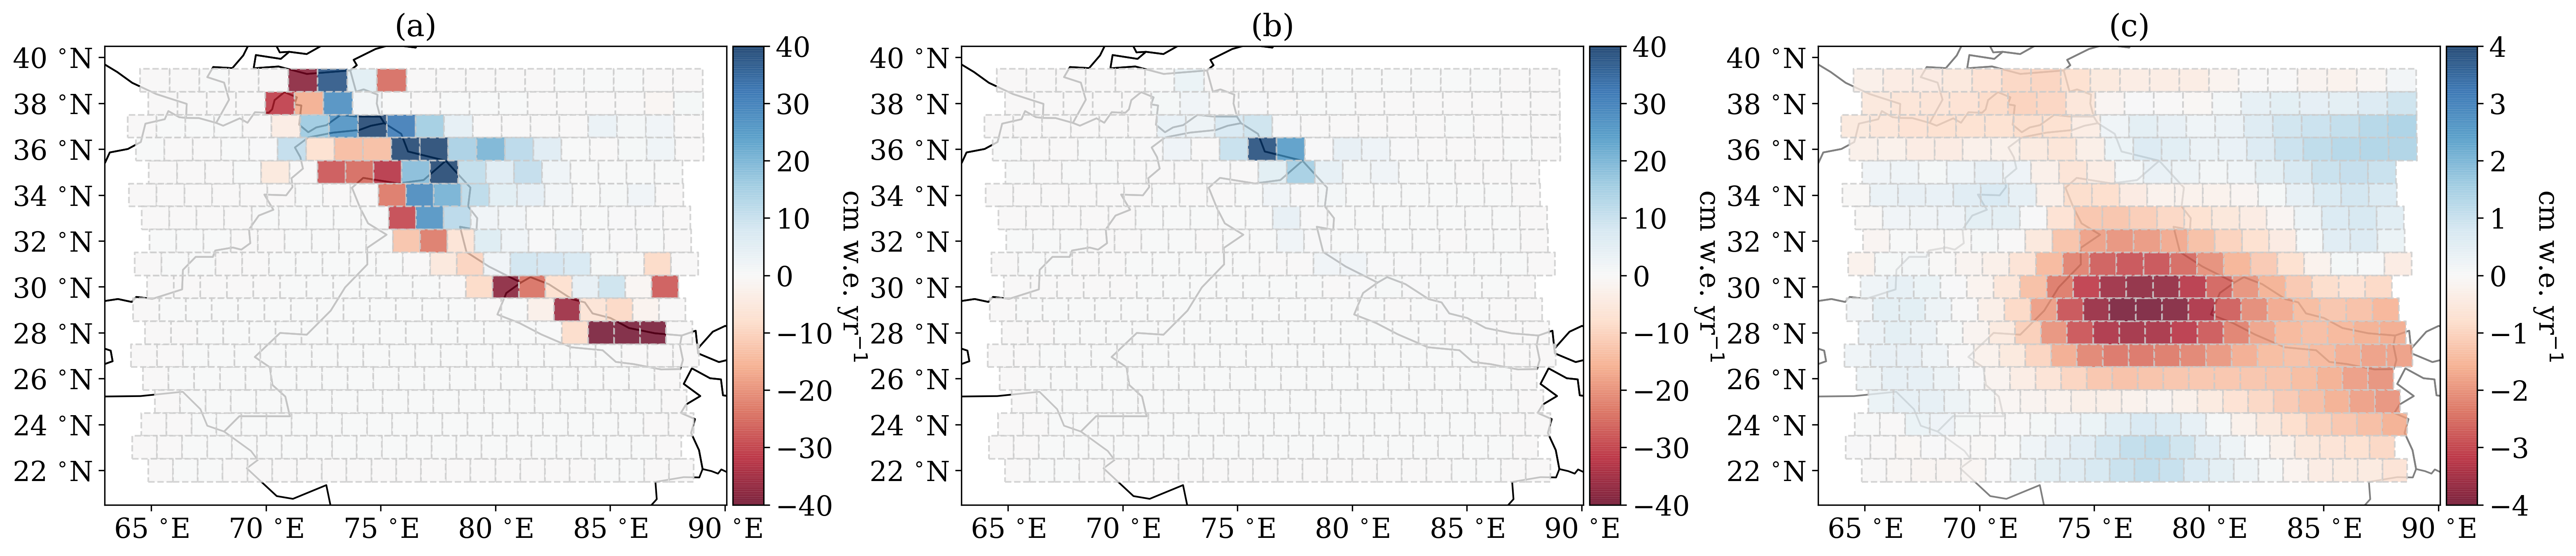

In [9]:
lw   = 2
ftsz = 18
matplotlib.rc('xtick', labelsize=ftsz-2)
matplotlib.rc('ytick', labelsize=ftsz-2) 
matplotlib.rc('font',**{'family':'serif','variant':'small-caps'})  

# ---> MODIFY HERE FOR FIGURE PARAMS
cmap = 'RdBu'
picfmt = 'png'
picdpi = 300
picdir = '.'
# <--- MODIFY HERE FOR FIGURE PARAMS


#first_df = copy(grc_trend_df )
#first_df['p1'] /= 10.

first_df  = copy(mar_trend_df )
second_df = copy(mar_tnice_df)
first_df['p1']  /= 10.
second_df['p1'] /= 10.

# --- setup basemap on lat/lon 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
HMA = world.query('continent == "Asia"')
#fig, axs = plt.subplots(3,1,figsize=(8.5,18),dpi=300)
fig, axs = plt.subplots(1,3,figsize=(24,7),dpi=300)

# --- plot 
im = HMA.plot(edgecolor='k', facecolor='none', lw=1,ax=axs[0])
hdl = first_df.plot(column='p1',edgecolor='.8',
                  vmin=-40,vmax=40,
                  ax=axs[0],alpha=.8,cmap=cmap,linestyle='--')
hdl.set_title('(a)',fontsize=ftsz,loc='center')

bbox = first_df.total_bounds
xbnds = [bbox[0]-1,bbox[2]+1]
ybnds = [bbox[1]-1,bbox[3]+1]
im.set_xlim(xbnds)
im.set_ylim(ybnds)

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im.collections[1],cax=cax,cmap=cmap)
cbar.set_label(r'cm w.e. yr$^{-1}$', rotation=270,fontsize=ftsz-2,labelpad=20)

xticks = np.arange(65,91,5).astype(int)
yticks = np.arange(22,41,2).astype(int)
im.set_yticks(yticks)
im.set_xticks(xticks)
txt_xticks = [str(x)+r' $^{\circ}$E' for x in xticks]
txt_yticks = [str(x)+r' $^{\circ}$N' for x in yticks]
im.set_xticklabels(txt_xticks);
im.set_yticklabels(txt_yticks);



# --- second: no ice 
axi = axs[1]
im = HMA.plot(edgecolor='k', facecolor='none', lw=1,ax=axi)
hdl = second_df.plot(column='p1',edgecolor='.8',
                  vmin=-40,vmax=40,
                  ax=axi,alpha=.8,cmap=cmap,linestyle='--')
hdl.set_title('(b)',fontsize=ftsz,loc='center')

bbox = first_df.total_bounds
xbnds = [bbox[0]-1,bbox[2]+1]
ybnds = [bbox[1]-1,bbox[3]+1]
im.set_xlim(xbnds)
im.set_ylim(ybnds)

divider = make_axes_locatable(axi)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im.collections[1],cax=cax,cmap=cmap)
cbar.set_label(r'cm w.e. yr$^{-1}$', rotation=270,fontsize=ftsz-2,labelpad=20)

im.set_yticks(yticks)
im.set_xticks(xticks)
im.set_xticklabels(txt_xticks);
im.set_yticklabels(txt_yticks);

# --- Grace:
axi = axs[2]
HMA.plot(edgecolor='.5', facecolor='none', lw=1,ax=axi)
im = HMA_w_trend.plot(column='avg_mass_change_cm',
                      vmin=-4,vmax=4,
                      edgecolor='.8',
                 ax=axi,alpha=.8,cmap=cmap,linestyle='--')
im.set_title('(c)',fontsize=ftsz,loc='center')

divider = make_axes_locatable(axi)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im.collections[1],cax=cax,cmap=cmap)
cbar.set_label(r'cm w.e. yr$^{-1}$', rotation=270,fontsize=ftsz-2,labelpad=20)


im.set_xlim(xbnds)
im.set_ylim(ybnds)
im.set_yticks(yticks)
im.set_xticks(xticks)
im.set_xticklabels(txt_xticks);
im.set_yticklabels(txt_yticks);

plt.subplots_adjust(left=.1,right=.9,top=.9,bottom=.1,wspace=.3)

picfn  = 'trend_map'+'.'+picfmt
picfn  = os.path.join(picdir,picfn)
#plt.savefig(picfn,format=picfmt,dpi=picdpi)

#### Example 2. Compare the time series of the domain averaged water content and linear trend

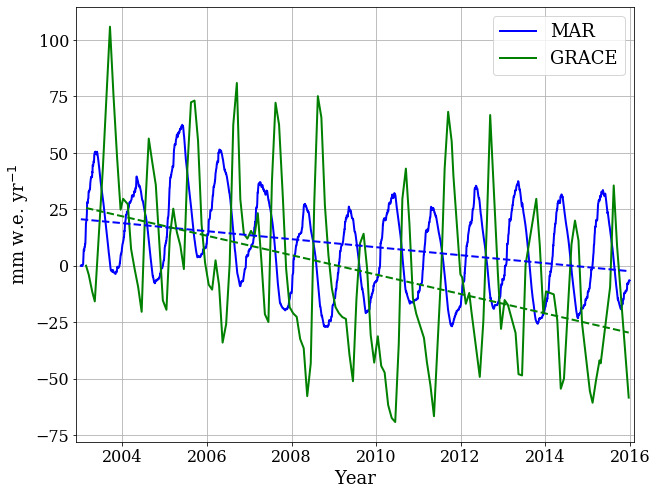

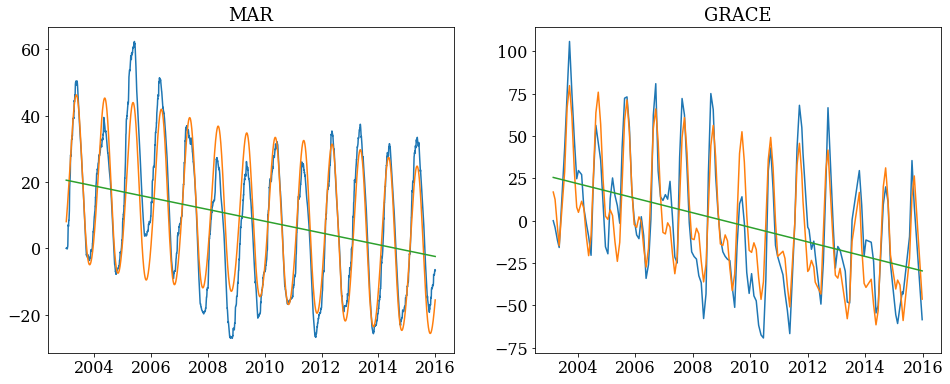

In [18]:
# --- read the aggregated MAR data and average 
ds = xr.open_mfdataset(agg_fns,concat_dim='time')
mardf = ds.to_dataframe()
mardf = mardf.reset_index(level='mascon')
mdf   = mardf['SMB_ice'].groupby('time').mean().cumsum().to_frame()

# --- avergate of GRACE data 
grct  = gracedf.groupby('time').mean()
tstart = '2003-01-07'
tend   = '2015-12-31'

# --- use only period between tstart and tend
pmdf = mdf.loc[tstart:tend]
pgrc = grct.loc[tstart:tend]
tdy_grc = np.array( list( map( pyasl.decimalYear , pgrc.index.to_pydatetime() ) ) ) 
tdy_mar = np.array( list( map( pyasl.decimalYear , pmdf.index.to_pydatetime() ) ) )
smb_mar = pmdf.SMB_ice
smb_grc = pgrc.mmwe

ts_mar = -smb_mar[0]+smb_mar
pval_mar = trend_analysis(tdy_mar,series=ts_mar,optimization=True)
pval_grc = trend_analysis(tdy_grc,series=smb_grc-smb_grc[0],optimization=True)

# --- calculated the fitted time series
fit_mar = trend_analysis(tdy_mar,pvalues=pval_mar)
fit_grc = trend_analysis(tdy_grc,pvalues=pval_grc)
lin_mar = pval_mar[0] + pval_mar[1]*tdy_mar
lin_grc = pval_grc[0] + pval_grc[1]*tdy_grc

plt.figure(2,figsize=(10,8))
plt.plot(tdy_mar,ts_mar,'-b',tdy_grc,smb_grc-smb_grc[0],'-g',lw=lw)
plt.legend(['MAR','GRACE'],fontsize=ftsz)
plt.plot(tdy_mar,lin_mar,'--b',tdy_grc,lin_grc,'--g',lw=lw)
plt.grid(True)
plt.xlabel('Year',fontsize=ftsz)
plt.ylabel(r'mm w.e. yr$^{-1}$',fontsize=ftsz)
plt.xlim([2002.9,2016.1])

picfn  = 'mean_ts_trend'+'.'+picfmt
picfn  = os.path.join(picdir,picfn)
#plt.savefig(picfn,format=picfmt,dpi=picdpi)

# ---> check fitted time series
plt.figure(3,figsize=(16,6))
plt.subplot(121)
plt.plot(tdy_mar,-smb_mar[0]+smb_mar,tdy_mar,fit_mar,tdy_mar,lin_mar)
plt.title('MAR',fontsize=ftsz);
plt.subplot(122)
plt.plot(tdy_grc,smb_grc-smb_grc[0],tdy_grc,fit_grc,tdy_grc,lin_grc)
plt.title('GRACE',fontsize=ftsz);